In [1]:
import ast
from collections import Counter
from gensim import utils, matutils 
from gensim.corpora.dictionary import Dictionary
from gensim.utils import deprecated
import itertools
from nltk.corpus import stopwords
import numpy as np
from numpy import linalg as LA
from numpy.random import binomial
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from numpy.linalg import norm
import math, copy, time
import warnings 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="talk")
%matplotlib inline

from keras import backend as K
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.models import load_model

import os, sys, re, io, nltk, torch
import pandas as pd

from scipy import stats
from scipy.stats import bernoulli
from scipy.stats import ortho_group  # Requires version 0.18 of scipy
from scipy.spatial import distance
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.preprocessing import Normalizer, normalize
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, recall_score, precision_score

from six import string_types, integer_types
from six.moves import zip, range
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from tqdm import tqdm, trange
import time
import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable
import re
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

stemmer_sn = SnowballStemmer("english")
stemmer = PorterStemmer()

stoplist = stopwords.words("english")
lemmatizer=WordNetLemmatizer()


'''
Compatible with tensorflow backend
gamma entre más alto más tolerante (queremos un gamma chico pero no demasiado! 0.25 - 5)
alpha pesos por clase (weights)
'''
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
class Dummy_Embeddings(nn.Module):
    def __init__(self, d_model, dummy_vectors): 
        super(Dummy_Embeddings, self).__init__()
        aux = torch.from_numpy(dummy_vectors)#, dtype='float32'))
        self.index2dummy = nn.Embedding(aux.size()[0], d_model)
        self.index2dummy.weigth=nn.Parameter(aux)
        self.index2dummy.weigth.requires_grad=False
        self.d_model = d_model
        
    def forward(self, x):
        aux=x.numpy()
        new_x= aux #- np.ones(aux.shape)
        new_x= torch.from_numpy(new_x)
        return self.index2dummy(new_x.long()) * math.sqrt(self.d_model) #debiese retornar matriz de batch_size x [ind_tw, k1,k2,k3,k4,k5,k6] (si son 6 modelos)
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
class EncoderDecoderLogSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderLogSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        out=self.encode(src, src_mask)
        retorno=self.toSoftmax(out)
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.log_softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class EncoderDecoderSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        out=self.encode(src, src_mask)
        retorno=self.toSoftmax(out)
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
            
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, src_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        self.generator = generator
        
    def forward(self, src, src_mask):
        return  self.encode(src, src_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))    
    
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)
    
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
    
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        #print ("mask para attn...", mask)
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
         
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
    
class PositionalText(nn.Module):
    def __init__(self, d_model, dropout, max_len=50):
        super(PositionalText, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x_text=x.data[:,0][:,None,:]
        x_machines=x.data[:,1:]
        
        x_return = x_machines* x_text
        return self.dropout(x_return)
    
class PositionalText_concat(nn.Module):
    def __init__(self, d_model, dropout, max_len=50):
        super(PositionalText_concat, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        return self.dropout(x)   

    
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    maximo=max(src_elements, tgt_elements)
    return maximo

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        #print ("Rate de Noam_opt", self._rate, self._step)
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        mask = torch.nonzero(target.data == self.padding_idx)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))
    
class LabelCCE(nn.Module):
    def __init__(self, class_weights):
        super(LabelCCE, self).__init__()
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
                       
    def forward(self, x, target):
        return self.criterion(x, target)
    
class FocalLoss(nn.Module):
    def __init__(self, weights, gamma=2.0, reduce=True):#, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.weights = weights
        self.gamma = gamma
        #self.logits = logits
        self.reduce = reduce

    def forward(self, x, y):
        tensors = []
        for l in y:
            tensors.append(torch.zeros(4).scatter_(0, torch.tensor(l), 1))
        result = torch.stack(tensors, 0)
        
        CCE_loss = F.cross_entropy(x, result.long().argmax(dim=-1), reduction='none', weight=self.weights.float())
        pt = torch.exp(-CCE_loss)
        factor= (1-pt)**self.gamma * CCE_loss
        
        F_loss = factor  #*self.weights.float()-- peso esta dentro de la funcion

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class SimpleLossComputeFL:
    "A simple loss compute and train function."
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm, mode):
        y_new=(y.float()-torch.ones((y.shape))).int() 
        #print ("nuevo Y en simplelosscompute", y_new, "antes era", y)
        # ahora
        #y_new=(y.float()).int()
        ac=accuracy_scorer(x, y_new)
        f1=f_scorer(x, y_new)
        cm=compute_confusion_matrix(x, y_new)
        tempa= x.contiguous().view(-1, x.size(-1))
        tempb= y_new.long().contiguous().view(-1)
        loss = self.criterion(tempa, tempb) #/ norm
        if mode!='Test':
            loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return [loss.data, ac ,f1, cm] #*norm #[0] * norm
    
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
def accuracy_scorer(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return accuracy_score(target.numpy(),predicho.numpy())

def f_scorer(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return f1_score(target.numpy(),predicho.numpy(), average=None, labels=[0,1,2,3])

def compute_confusion_matrix(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return confusion_matrix(target.numpy(), predicho.numpy(), labels=[0,1,2,3])

def data_gen(batch_size,mode):    
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=x_train.shape[0]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)        #indices desordenados de seccion train
        objs=ids_train
        labels=etiq     #np.load("matrices/y_train_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8')
    if mode=='Val':
        max_objs=x_val.shape[0] 
        x_list=np.arange(max_objs)
        x_list=[x+x_train.shape[0] for x in x_list]   
        np.random.shuffle(x_list)        #indices desordenados de seccion val
        objs=val['tweet_id']    #df_val['Unnamed: 0'].values        
        labels=np.asarray(etiq_v)     #np.load("matrices/y_val_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8') 
    if mode=='Test':
        max_objs=x_test.shape[0] 
        x_list=np.arange(max_objs)
        x_list=[x+x_train.shape[0]+x_val.shape[0] for x in x_list]
        total=x_train.shape[0]+x_val.shape[0]
        objs=test['tweet_id']     #np.arange(total, total+max_objs)
        
    #----------------------------------- COMPLETA MINI BATCHES ----------------------  
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
            
    #-------------------------------- CONSTRUCCION MINI BATCHES (X,Y)----------------------   
    new_x_data=[] 
    for batch in x_data:
        temp=[]
        for pos in batch:
            temp2=[index_embeddings[pos+5]]
            temp.append(temp2)
        new_x_data.append(temp)  

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for conjunto in range(len(new_x_data)):
            batch=new_x_data[conjunto]
            temp_y=[]
            for linea in range(len(batch)):
                indice=x_data[conjunto][linea]  #pos
                lab=d_lab[lab_str_embeddings[indice+5]]+1 #labels_train
                temp_y.append([lab])       
            y_data.append(temp_y)
            
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)

    if mode=='Test':
        for x in new_x_data:
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)        
    else:          
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)   


def make_model_concat(target, N=2, d_model=768, d_ff=1024, h=4, dropout=0.3, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText_concat(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :]
            self.trg_y = trg[:, 0:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask
    
def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                #print ("batch.src_mask en run epoch", batch.src_mask)
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
                #la loss del batch es sobre todos los ejemplos o es promedio en batch?
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):
            #print ("BATCH\n", i, '\n', batch.src)
            out = model.forward(batch.src, batch.src_mask)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0    #4 clases (macro)
            total_fs += f1                 #none  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleaner(post): 
    s= re.sub(r"http\S+", " <html> ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " <hashtag> ", s) ########3
    s= re.sub(r'@\w+ ?', " <user> ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    #“
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " <number> ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=Word2Index_valid[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in Word2Index_valid.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in Word2Index_valid.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl


embeddings_index = {}
f = open(os.path.join("glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB
Se encontraron 1193514 terminos con sus vectores de embedding.


In [2]:
train =pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Harassment/train_format.csv")
val=pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Harassment/val_format.csv")
test=pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Harassment/test_format.csv")

dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

word_index=dict()
j=1
for frase in train["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1

for frase in val["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            
for frase in test["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            
len(word_index.keys())

22107

In [3]:
not_found=[]
pos_tag_nf=[]
Word2Index={}
Word2Index_valid={}
idx_2_token={}
idx_2_token_valid={}

g_dim=200
emb_matrix = np.zeros((len(word_index.keys())+1, g_dim))  

k=1
for word, i in word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        # words sin match en Glove, serán vectores de ceros.
        emb_matrix[i] = vector
        Word2Index[word]=i
        Word2Index_valid[word]=k
        idx_2_token_valid[k]=word
        k+=1
        idx_2_token[i]=word
        
    else:
        Word2Index[word]=i
        idx_2_token[i]=word
        not_found.append(word)
        pos_tag_nf.append(nltk.pos_tag([word])[0][-1])

        
glove_matrix = np.zeros((k, g_dim))

for word, i in Word2Index_valid.items():
    vector = embeddings_index.get(word)    
    glove_matrix[i] = vector
    
glove_matrix.shape

(14642, 200)

In [4]:
print (len(Word2Index_valid.keys()))

14641


In [5]:
len(Word2Index.keys())

22107

In [6]:
#transf = Normalizer().fit(glove_matrix) 
#M_GLOVE_space=transf.transform(glove_matrix)
M_GLOVE_space=glove_matrix

def my_tokenizer(lista):
    encoded_sent=[]
    to_return_ide=[]
    for wd in lista:
        try:               
            to_return_ide.append(Word2Index_valid[wd])
            encoded_sent.append(wd)
        except: 
            continue   
           
    return to_return_ide, encoded_sent

def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [7]:
from models import *

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
class Dummy_Embeddings(nn.Module):
    def __init__(self, d_model, dummy_vectors): 
        super(Dummy_Embeddings, self).__init__()
        aux = torch.from_numpy(dummy_vectors)#, dtype='float32'))
        self.index2dummy = nn.Embedding(aux.size()[0], d_model)
        self.index2dummy.weigth=nn.Parameter(aux)
        self.index2dummy.weigth.requires_grad=False
        self.d_model = d_model
        
    def forward(self, x):
        aux=x.numpy()
        #print ("aux original", aux)
        #print ("aux restado...",aux-np.ones(aux.shape))
        new_x= aux #- np.ones(aux.shape)
        new_x= torch.from_numpy(new_x)
        return self.index2dummy(new_x.long()) * math.sqrt(self.d_model) #debiese retornar matriz de batch_size x [ind_tw, k1,k2,k3,k4,k5,k6] (si son 6 modelos)
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
MAX_LEN = 37

print ("Conteo por harassment val\n", Counter(val['Label']))
print ("Conteo por harassment test\n", Counter(test['Label']))


Conteo por harassment val
 Counter({'NonH': 1493, 'SexualH': 525, 'IndirectH': 71, 'PhysicalH': 36})
Conteo por harassment test
 Counter({'NonH': 1601, 'SexualH': 340, 'IndirectH': 106, 'PhysicalH': 76})


In [8]:
ids_train=train['tweet_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)
#print ("Pesos de clases:", class_weights)

etiq=labels_train.copy()
etiq=np.asarray(etiq)
sentences = tws_train
n_labels = np.array(etiq)
y_train=to_categorical(n_labels,num_classes=4)


input_ids=[]
for sent in sentences:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])  
    input_ids.append(encoded_sent) 
    
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], 200))
j=0
for in_id in input_ids:
    x_train[j]=M_GLOVE_space[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]


In [9]:
ids_val=val['tweet_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

etiq_v=labels_val.copy()
etiq_v=np.asarray(etiq_v)
sentences_val = tws_val
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)

input_ids_val=[]
for sent in sentences_val:
    encoded_sent, sent_valid =my_tokenizer(cleaner(sent)[1])  
    input_ids_val.append(encoded_sent)

ids_test=test['tweet_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

etiq_t=labels_test.copy()
etiq_t=np.asarray(etiq_t)
sentences_test = tws_test
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids_test=[]
for sent in sentences_test:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])
    input_ids_test.append(encoded_sent)
    
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")


shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 200))
i=0
for in_id in input_ids_val:
    x_val[i]=M_GLOVE_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 200))
i=0
for in_id in input_ids_test:
    x_test[i]=M_GLOVE_space[in_id]
    i+=1

x_test.shape

(2123, 37, 200)

In [10]:
del embeddings_index

In [11]:
from bert_serving.client import BertClient
bc = BertClient()

In [15]:
class_weights

array([1., 1., 1., 1.])

### 0.0 No CW

Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.41138059701492535 	F-macro_val: 0.2078265268422165
Epoch 10 	acc_val: 0.6763059701492538 	F-macro_val: 0.21544654625747425
Epoch 20 	acc_val: 0.695429104477612 	F-macro_val: 0.23234754114121875
Epoch 30 	acc_val: 0.7028917910447762 	F-macro_val: 0.22386298530265022
Epoch 40 	acc_val: 0.7033582089552238 	F-macro_val: 0.21719949556378784
Epoch 50 	acc_val: 0.6963619402985075 	F-macro_val: 0.24447383912330442
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


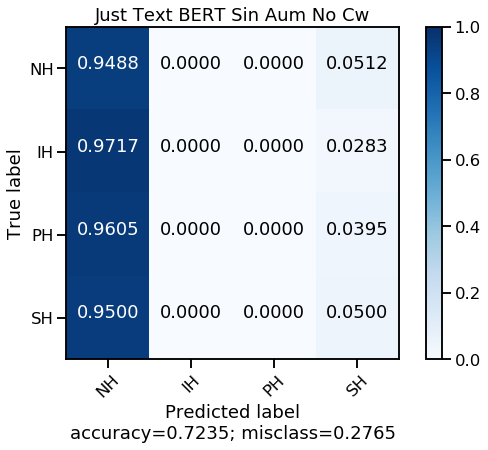

Test_ acc: 0.7235044747998116
Test_ f1 none: [0.83945841 0.         0.         0.07640449]
Test_ f1 macro: 0.2289657270771304
Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.355410447761194 	F-macro_val: 0.21005318251954505
Epoch 10 	acc_val: 0.6777052238805971 	F-macro_val: 0.22342621690253237
Epoch 20 	acc_val: 0.6996268656716418 	F-macro_val: 0.23772865481673897
Epoch 30 	acc_val: 0.6940298507462687 	F-macro_val: 0.24744617358560672
Epoch 40 	acc_val: 0.7028917910447762 	F-macro_val: 0.2510983056202835
Epoch 50 	acc_val: 0.7000932835820896 	F-macro_val: 0.253558060796277
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


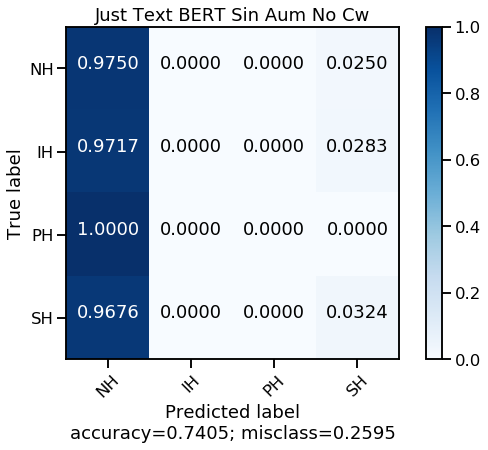

Test_ acc: 0.7404616109279322
Test_ f1 none: [0.8506812  0.         0.         0.05583756]
Test_ f1 macro: 0.22662969059046462
Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.33722014925373134 	F-macro_val: 0.1981807992068603
Epoch 10 	acc_val: 0.6823694029850746 	F-macro_val: 0.21858466644799945
Epoch 20 	acc_val: 0.7000932835820896 	F-macro_val: 0.24083567015328058
Epoch 30 	acc_val: 0.7056902985074627 	F-macro_val: 0.22630463993378114
Epoch 40 	acc_val: 0.7056902985074627 	F-macro_val: 0.24416359714323815
Epoch 50 	acc_val: 0.7131529850746269 	F-macro_val: 0.24354274255052824
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


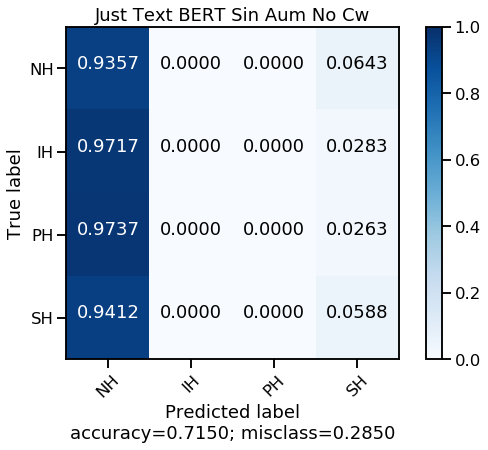

Test_ acc: 0.7150259067357513
Test_ f1 none: [0.83314794 0.         0.         0.08547009]
Test_ f1 macro: 0.2296545069070097
Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.27098880597014924 	F-macro_val: 0.17147768454826534
Epoch 10 	acc_val: 0.6907649253731343 	F-macro_val: 0.2175156310134918
Epoch 20 	acc_val: 0.6996268656716418 	F-macro_val: 0.22552750309651462
Epoch 30 	acc_val: 0.7010261194029851 	F-macro_val: 0.22154424150214178
Epoch 40 	acc_val: 0.7038246268656716 	F-macro_val: 0.239424798783614
Epoch 50 	acc_val: 0.7075559701492538 	F-macro_val: 0.22809594552626994
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


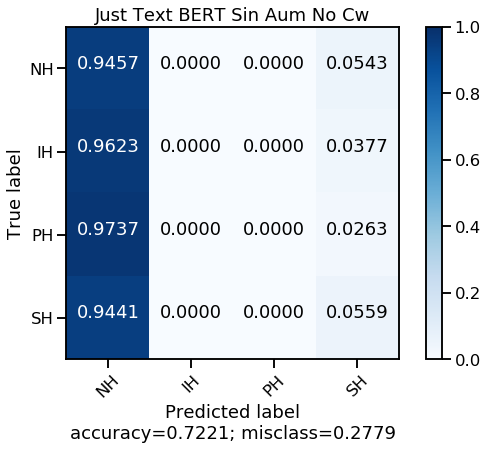

Test_ acc: 0.7220913801224682
Test_ f1 none: [0.83831672 0.         0.         0.0840708 ]
Test_ f1 macro: 0.23059687962445732
Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.2728544776119403 	F-macro_val: 0.1851113566394369
Epoch 10 	acc_val: 0.6716417910447762 	F-macro_val: 0.2303853527474895
Epoch 20 	acc_val: 0.6786380597014925 	F-macro_val: 0.2417001517066105
Epoch 30 	acc_val: 0.7024253731343284 	F-macro_val: 0.22489673129392546
Epoch 40 	acc_val: 0.6921641791044776 	F-macro_val: 0.24061624201008547
Epoch 50 	acc_val: 0.6944962686567164 	F-macro_val: 0.2438741098674326
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


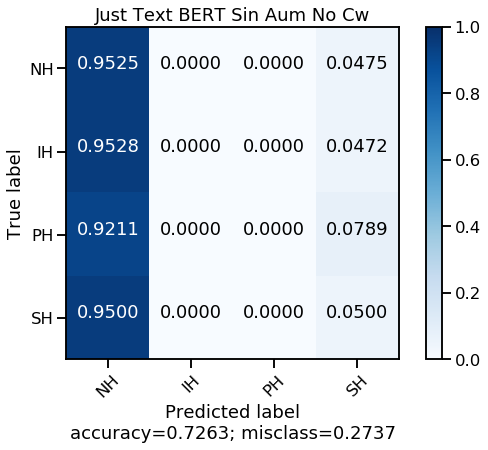

Test_ acc: 0.7263306641544983
Test_ f1 none: [0.84254144 0.         0.         0.07657658]
Test_ f1 macro: 0.22977950326016622


In [15]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}
  
prob=0.0

for trans in range(1,6): 
    print ("Entrenando Run #", trans)
    
    bs=32
    b_dim=768
    
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']

    for i in range(len(sentences)):
        #ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        encoded_tok, sentence_valid = my_tokenizer(cleaner(tw_tr)[1])  #cleaner: raw, no cleaner:augmented version
                
        final=' '
        frase=[final.join(sentence_valid)]
        try: 
            vector= bc.encode(frase)[0]  
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)
            
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
    objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
      
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        #vector=np.load("../BaS_Original/Original/"+str(i)+".npy")
        encoded_tok, tokens_valid =my_tokenizer(cleaner(tw_tr)[1])
    
        final=' '
        frase=[final.join(tokens_valid)]
        try: 
            vector= bc.encode(frase)[0]    
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    ###################################### TRANSFORMER ###############################
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

    
    for epoch in range(60):
        model.train()
        DATA=data_gen(bs, 'Train')
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val'), model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val:",acc_val.numpy(), "\tF-macro_val:",fma_val.numpy())
    
    model.eval()
    print ("Testing run #",trans)
    predicciones = run_epoch(data_gen(bs, 'Test'), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-21])
    glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

    plot_confusion_matrix(glo_cm,["NH","IH","PH","SH"],"Just Text BERT Sin Aum No Cw")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 


In [16]:
print ("Acc:",np.mean(np.asarray(global_accs)))
print ("F-score:", np.mean(np.asarray(global_fmacros)))
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.0_No CW) Text - NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
    
m_temp

Acc: 0.7254828073480922
F-score: 0.22912526149184567
(0.0_No CW) Text - NIPS: 0.840829142699255 0.0 0.0 0.07567190326812764


Confusion counts


array([[7617.,    0.,    0.,  388.],
       [ 512.,    0.,    0.,   18.],
       [ 367.,    0.,    0.,   13.],
       [1616.,    0.,    0.,   84.]])

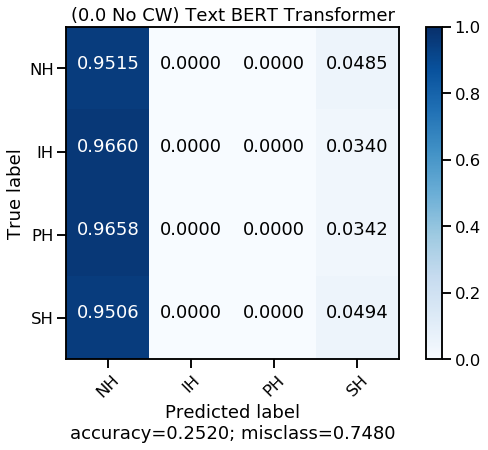

In [17]:
plot_confusion_matrix(normalize(m_temp),["NH","IH","PH","SH"],"(0.0 No CW) Text BERT Transformer", cmap='Blues')

### 0.0 Con CW

In [18]:
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)

print ("Pesos de clases:", class_weights)
#print ("Pesos de clases:", class_weights)

Pesos de clases: [ 0.43526359 28.97272727 20.96710526  0.61715724]


Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.251865671641791 	F-macro_val: 0.17094465020613148
Epoch 10 	acc_val: 0.06856343283582089 	F-macro_val: 0.07001827909525894
Epoch 20 	acc_val: 0.05503731343283582 	F-macro_val: 0.05405842353224153
Epoch 30 	acc_val: 0.09841417910447761 	F-macro_val: 0.1014259995273597
Epoch 40 	acc_val: 0.1259328358208955 	F-macro_val: 0.12391827347267158
Epoch 50 	acc_val: 0.1609141791044776 	F-macro_val: 0.15442531793285857
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


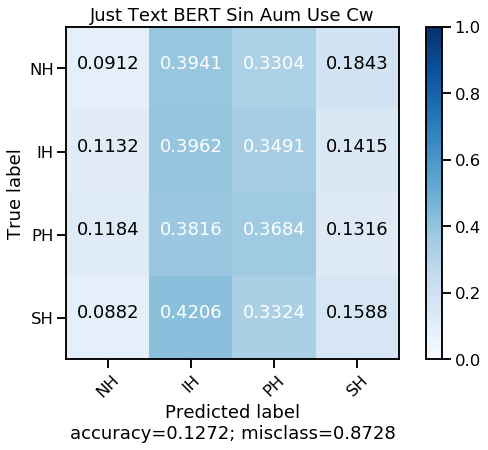

Test_ acc: 0.12717852096090437
Test_ f1 none: [0.16240267 0.08832808 0.0715198  0.1512605 ]
Test_ f1 macro: 0.118377761300528
Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.2733208955223881 	F-macro_val: 0.180882770251316
Epoch 10 	acc_val: 0.07602611940298508 	F-macro_val: 0.0781145686834036
Epoch 20 	acc_val: 0.05643656716417911 	F-macro_val: 0.05928136946813501
Epoch 30 	acc_val: 0.10167910447761194 	F-macro_val: 0.10263900057129903
Epoch 40 	acc_val: 0.13246268656716417 	F-macro_val: 0.1283205064023142
Epoch 50 	acc_val: 0.1730410447761194 	F-macro_val: 0.15729305064717203
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


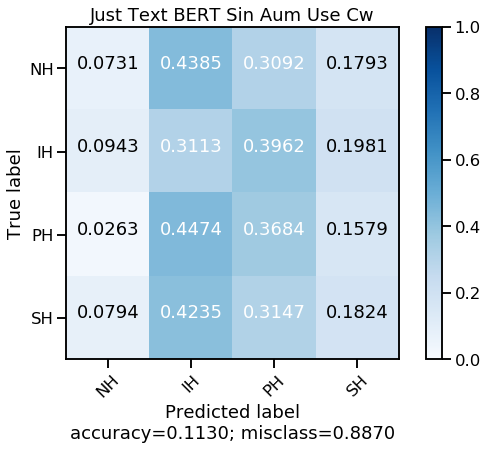

Test_ acc: 0.11304757418747056
Test_ f1 none: [0.13318156 0.06476938 0.07486631 0.17174515]
Test_ f1 macro: 0.11114060093454729
Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.3306902985074627 	F-macro_val: 0.20533078983370556
Epoch 10 	acc_val: 0.07649253731343283 	F-macro_val: 0.07408168991952398
Epoch 20 	acc_val: 0.05177238805970149 	F-macro_val: 0.04815136326022655
Epoch 30 	acc_val: 0.08162313432835822 	F-macro_val: 0.08132878118037128
Epoch 40 	acc_val: 0.15205223880597016 	F-macro_val: 0.13642603989361152
Epoch 50 	acc_val: 0.1814365671641791 	F-macro_val: 0.1609581604108863
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


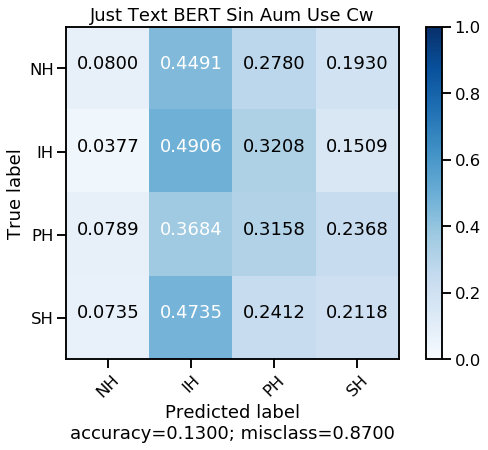

Test_ acc: 0.13000471031559113
Test_ f1 none: [0.14512472 0.09756098 0.07261725 0.19072848]
Test_ f1 macro: 0.12650785389507568
Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.27425373134328357 	F-macro_val: 0.1686414954247943
Epoch 10 	acc_val: 0.06203358208955224 	F-macro_val: 0.057490315415676174
Epoch 20 	acc_val: 0.054104477611940295 	F-macro_val: 0.0545877905962882
Epoch 30 	acc_val: 0.11240671641791045 	F-macro_val: 0.10993376199200329
Epoch 40 	acc_val: 0.12173507462686567 	F-macro_val: 0.12161790753559888
Epoch 50 	acc_val: 0.1669776119402985 	F-macro_val: 0.15726291288086447
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


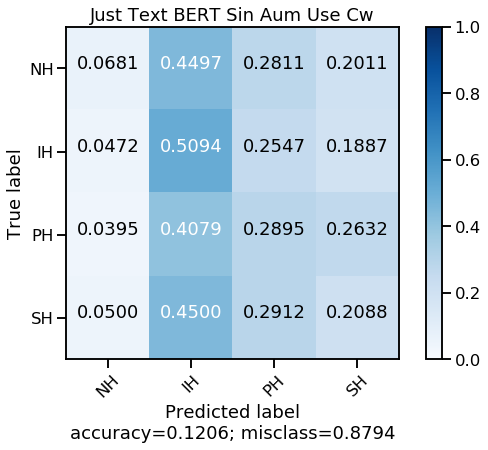

Test_ acc: 0.12058407913330194
Test_ f1 none: [0.12564841 0.10150376 0.0652819  0.18369987]
Test_ f1 macro: 0.1190334860319433
Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.11380597014925373 	F-macro_val: 0.10204233164145456
Epoch 10 	acc_val: 0.05970149253731343 	F-macro_val: 0.06444387248310154
Epoch 20 	acc_val: 0.05970149253731343 	F-macro_val: 0.06200769893673046
Epoch 30 	acc_val: 0.10027985074626866 	F-macro_val: 0.10447259273413281
Epoch 40 	acc_val: 0.10680970149253731 	F-macro_val: 0.10957207912636284
Epoch 50 	acc_val: 0.14225746268656717 	F-macro_val: 0.13629768104937393
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


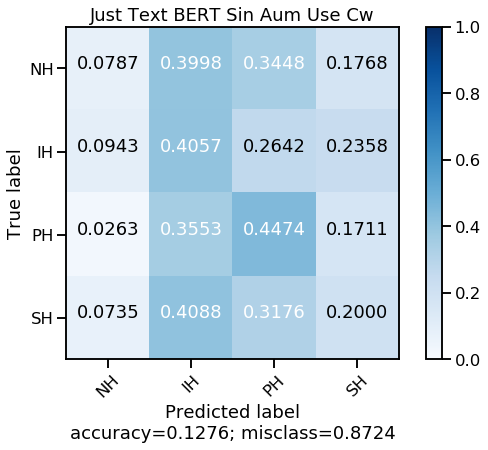

Test_ acc: 0.12764955252001883
Test_ f1 none: [0.14285714 0.09005236 0.08521303 0.18655693]
Test_ f1 macro: 0.12616986468930175


In [19]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}
  
prob=0.0

for trans in range(1,6): 
    print ("Entrenando Run #", trans)
    
    bs=32
    b_dim=768
    
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']

    for i in range(len(sentences)):
        #ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        encoded_tok, sentence_valid = my_tokenizer(cleaner(tw_tr)[1])  #cleaner: raw, no cleaner:augmented version
                
        final=' '
        frase=[final.join(sentence_valid)]
        try: 
            vector= bc.encode(frase)[0]  
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)
            
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
    objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
      
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        #vector=np.load("../BaS_Original/Original/"+str(i)+".npy")
        encoded_tok, tokens_valid =my_tokenizer(cleaner(tw_tr)[1])
    
        final=' '
        frase=[final.join(tokens_valid)]
        try: 
            vector= bc.encode(frase)[0]    
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    ###################################### TRANSFORMER ###############################
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))
    
    for epoch in range(60):
        model.train()
        DATA=data_gen(bs, 'Train')
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val'), model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val:",acc_val.numpy(), "\tF-macro_val:",fma_val.numpy())
    
    model.eval()
    print ("Testing run #",trans)
    predicciones = run_epoch(data_gen(bs, 'Test'), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-21])
    glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

    plot_confusion_matrix(glo_cm,["NH","IH","PH","SH"],"Just Text BERT Sin Aum Use Cw")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 


In [20]:
print ("Acc:",np.mean(np.asarray(global_accs)))
print ("F-score:", np.mean(np.asarray(global_fmacros)))
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.0_Use CW) Text - NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
    
m_temp

Acc: 0.12369288742345737
F-score: 0.1202459133702792
(0.0_Use CW) Text - NIPS: 0.14184290070106545 0.0884429096971569 0.07389965682109338 0.17679818626180105


Confusion counts


array([[ 626., 3412., 2471., 1496.],
       [  41.,  224.,  168.,   97.],
       [  22.,  149.,  136.,   73.],
       [ 124.,  740.,  509.,  327.]])

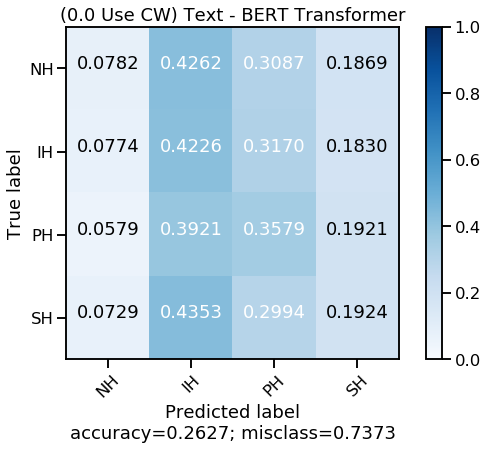

In [21]:
plot_confusion_matrix(normalize(m_temp),["NH","IH","PH","SH"],"(0.0 Use CW) Text - BERT Transformer", cmap='Blues')

In [26]:
"bert listo pausa"

'bert listo pausa'

## 0.15

In [22]:
val['Tweet'][0]

'RT GLOSSPHOENIX some of y all never watched collected and fucked with the bratz movies and it shows '

Entrenando Run # 1
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.20662313432835822 	F-macro_val: 0.14523823775538616
Epoch 10 	acc_val: 0.345615671641791 	F-macro_val: 0.20783485970088195
Epoch 20 	acc_val: 0.35447761194029853 	F-macro_val: 0.22885256145650273
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


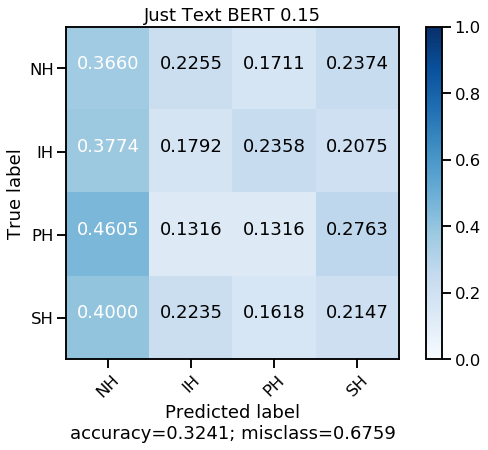

Test_ acc: 0.32406971267074897
Test_ f1 none: [0.48874062 0.06643357 0.04545455 0.17464115]
Test_ f1 macro: 0.1938174693486137
Entrenando Run # 2
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.283115671641791 	F-macro_val: 0.17465383740102994
Epoch 10 	acc_val: 0.2966417910447761 	F-macro_val: 0.19307097706614668
Epoch 20 	acc_val: 0.39598880597014924 	F-macro_val: 0.23171616716414953
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


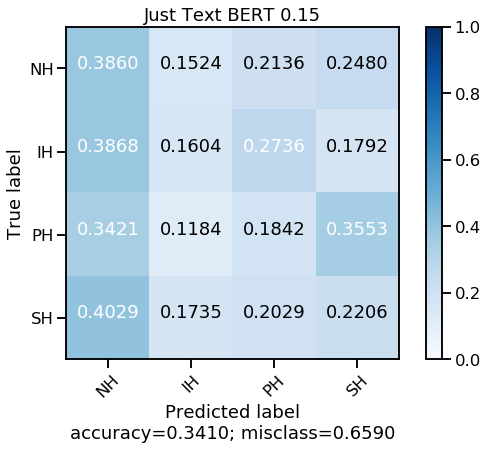

Test_ acc: 0.3410268487988695
Test_ f1 none: [0.51011143 0.07816092 0.05283019 0.17482517]
Test_ f1 macro: 0.20398192878840143
Entrenando Run # 3
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.14832089552238806 	F-macro_val: 0.11876764582671658
Epoch 10 	acc_val: 0.269589552238806 	F-macro_val: 0.18435073161742846
Epoch 20 	acc_val: 0.33488805970149255 	F-macro_val: 0.2074508316156853
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


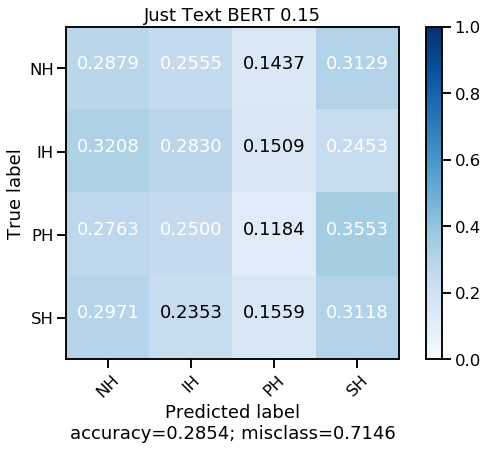

Test_ acc: 0.28544512482336315
Test_ f1 none: [0.41568981 0.0931677  0.046875   0.212     ]
Test_ f1 macro: 0.1919331281258926
Entrenando Run # 4
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.2635261194029851 	F-macro_val: 0.1632825241716152
Epoch 10 	acc_val: 0.24486940298507462 	F-macro_val: 0.1712747191866794
Epoch 20 	acc_val: 0.2933768656716418 	F-macro_val: 0.1916880003544103
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


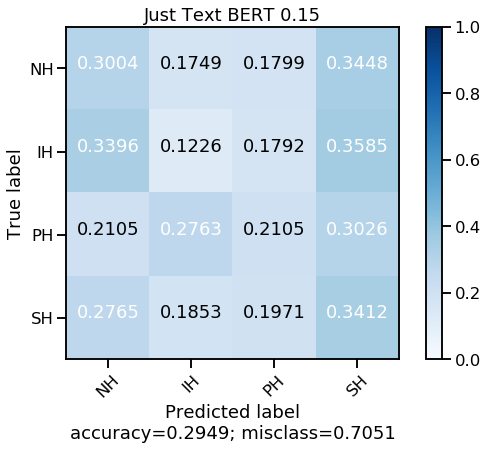

Test_ acc: 0.2948657560056524
Test_ f1 none: [0.43177738 0.05383023 0.06866953 0.21702526]
Test_ f1 macro: 0.19282559792627846
Entrenando Run # 5
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.23880597014925373 	F-macro_val: 0.16142018042538586
Epoch 10 	acc_val: 0.332089552238806 	F-macro_val: 0.2158221086302043
Epoch 20 	acc_val: 0.3498134328358209 	F-macro_val: 0.21969260009021735
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


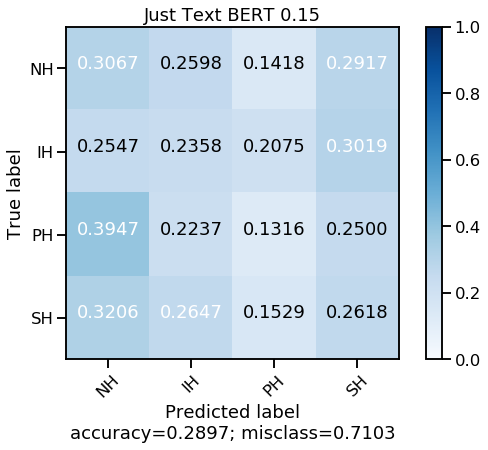

Test_ acc: 0.2896844088553933
Test_ f1 none: [0.43489814 0.0764526  0.05167959 0.18796199]
Test_ f1 macro: 0.18774807777875388


In [23]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}
  
prob=0.15

for trans in range(1,6): 
    print ("Entrenando Run #", trans)
    macro_augmented= np.load('../new_glove_augmented/harassment/Aumento_'+str(trans)+'-run_'+str(prob)+'_app1_Top1.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        
    bs=32
    b_dim=768
    
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']


    for i in range(len(sentences)):
        ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        
        #tws_train[i]
        final=' '
        frase=[final.join(tw_tr)]
        try: 
            vector= bc.encode(frase)[0]  
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)
        
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    
    objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
    objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
    
       
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        #vector=np.load("../BaS_Original/Original/"+str(i)+".npy")
        encoded_tok, tokens_valid =my_tokenizer(cleaner(tw_tr)[1])
    
        final=' '
        frase=[final.join(tokens_valid)]
        try: 
            vector= bc.encode(frase)[0]    
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    ###################################### TRANSFORMER ###############################
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))
    
    
    for epoch in range(26):
        model.train()
        DATA=data_gen(bs, 'Train')
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val'), model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val:",acc_val.numpy(), "\tF-macro_val:",fma_val.numpy())
    
    model.eval()
    print ("Testing run #",trans)
    predicciones = run_epoch(data_gen(bs, 'Test'), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-21])
    glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

    plot_confusion_matrix(glo_cm,["NH","IH","PH","SH"],"Just Text BERT 0.15")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 

In [24]:
print ("Acc:",np.mean(np.asarray(global_accs)))
print ("F-score:", np.mean(np.asarray(global_fmacros)))
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.15) Text - NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
m_temp

Acc: 0.30701837023080547
F-score: 0.19406124039358802
(0.15) Text - NIPS: 0.4562434757384185 0.07360900299376016 0.05310176971881879 0.1932907131233546


Confusion counts


array([[2637., 1710., 1361., 2297.],
       [ 178.,  104.,  111.,  137.],
       [ 128.,   76.,   59.,  117.],
       [ 577.,  368.,  296.,  459.]])

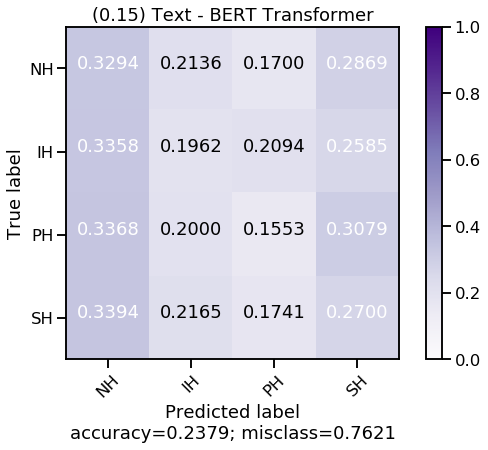

In [25]:
plot_confusion_matrix(normalize(m_temp),["NH","IH","PH","SH"],"(0.15) Text - BERT Transformer", cmap='Purples')

### 0.5

Entrenando Run # 1
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.33348880597014924 	F-macro_val: 0.19809296622054207
Epoch 10 	acc_val: 0.32882462686567165 	F-macro_val: 0.20950957847193755
Epoch 20 	acc_val: 0.36847014925373134 	F-macro_val: 0.23209493485212646
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


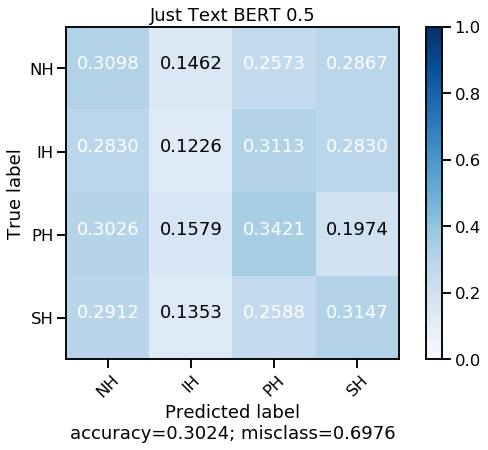

Test_ acc: 0.30240226095148376
Test_ f1 none: [0.44108493 0.06326034 0.08188976 0.22502629]
Test_ f1 macro: 0.20281532979099032
Entrenando Run # 2
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.25466417910447764 	F-macro_val: 0.1684169111307483
Epoch 10 	acc_val: 0.28777985074626866 	F-macro_val: 0.1847226166629826
Epoch 20 	acc_val: 0.33488805970149255 	F-macro_val: 0.20162095734033345
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


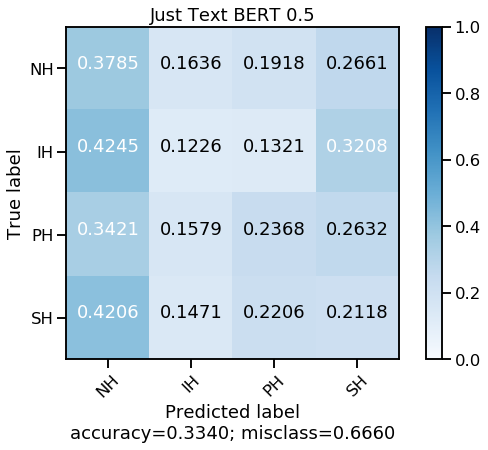

Test_ acc: 0.3339613754121526
Test_ f1 none: [0.50061958 0.05869074 0.07346939 0.16143498]
Test_ f1 macro: 0.19855367223526596
Entrenando Run # 3
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.25279850746268656 	F-macro_val: 0.17814241314684656
Epoch 10 	acc_val: 0.32136194029850745 	F-macro_val: 0.21493029651512222
Epoch 20 	acc_val: 0.34654850746268656 	F-macro_val: 0.22498598037377454
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


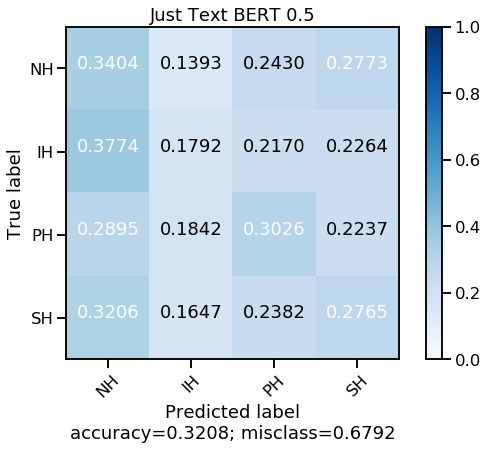

Test_ acc: 0.3207724917569477
Test_ f1 none: [0.47043591 0.09090909 0.0777027  0.20457018]
Test_ f1 macro: 0.21090447177446134
Entrenando Run # 4
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.28031716417910446 	F-macro_val: 0.18968982659996395
Epoch 10 	acc_val: 0.283115671641791 	F-macro_val: 0.18894251219168168
Epoch 20 	acc_val: 0.42490671641791045 	F-macro_val: 0.23793241723513275
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


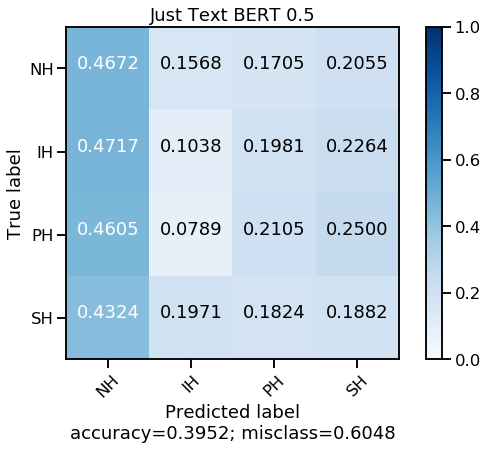

Test_ acc: 0.3951954780970325
Test_ f1 none: [0.5796203  0.04988662 0.07142857 0.16494845]
Test_ f1 macro: 0.21647098714011448
Entrenando Run # 5
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.2947761194029851 	F-macro_val: 0.1911112508268492
Epoch 10 	acc_val: 0.26865671641791045 	F-macro_val: 0.18624192862377334
Epoch 20 	acc_val: 0.3400186567164179 	F-macro_val: 0.22575658581887392
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


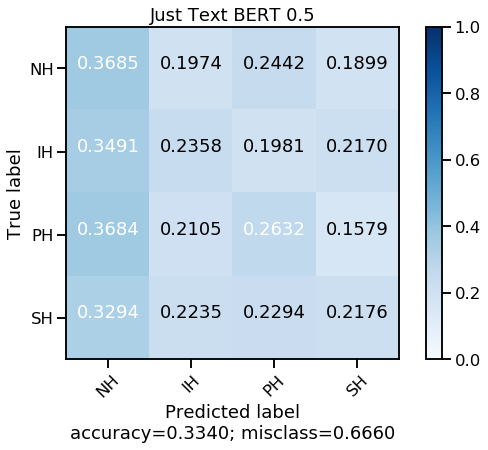

Test_ acc: 0.3339613754121526
Test_ f1 none: [0.49831081 0.09276438 0.06825939 0.19654714]
Test_ f1 macro: 0.21397042992733


In [26]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}
  
prob=0.5

for trans in range(1,6): 
    print ("Entrenando Run #", trans)
    macro_augmented= np.load('../new_glove_augmented/harassment/Aumento_'+str(trans)+'-run_'+str(prob)+'_app1_Top1.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        
    bs=32
    b_dim=768
    
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']


    for i in range(len(sentences)):
        ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        
        #tws_train[i]
        final=' '
        frase=[final.join(tw_tr)]
        try: 
            vector= bc.encode(frase)[0]  
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)
        
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    
    objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
    objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
    
       
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        #vector=np.load("../BaS_Original/Original/"+str(i)+".npy")
        encoded_tok, tokens_valid =my_tokenizer(cleaner(tw_tr)[1])
    
        final=' '
        frase=[final.join(tokens_valid)]
        try: 
            vector= bc.encode(frase)[0]    
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    
    ###################################### TRANSFORMER ###############################
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))
    
    
    for epoch in range(26):
        model.train()
        DATA=data_gen(bs, 'Train')
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val'), model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val:",acc_val.numpy(), "\tF-macro_val:",fma_val.numpy())
    
    model.eval()
    print ("Testing run #",trans)
    predicciones = run_epoch(data_gen(bs, 'Test'), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-21])
    glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

    plot_confusion_matrix(glo_cm,["NH","IH","PH","SH"],"Just Text BERT 0.5")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 

In [27]:
print ("Acc:",np.mean(np.asarray(global_accs)))
print ("F-score:", np.mean(np.asarray(global_fmacros)))
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.5) Text - NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
m_temp

Acc: 0.33725859632595384
F-score: 0.2085429781736324
(0.5) Text - NIPS: 0.4980143053684367 0.0711022352513089 0.07454996226628655 0.1905054098084975


Confusion counts


array([[2985., 1286., 1772., 1962.],
       [ 202.,   81.,  112.,  135.],
       [ 134.,   60.,  103.,   83.],
       [ 610.,  295.,  384.,  411.]])

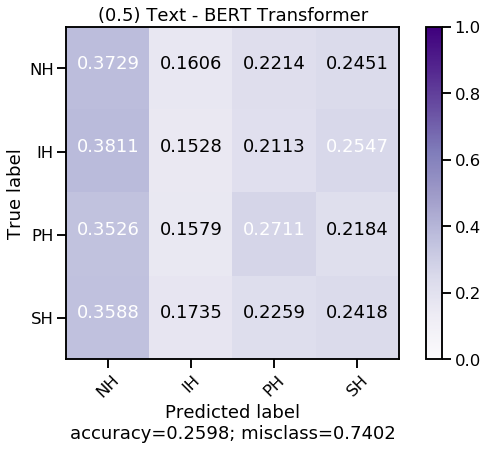

In [28]:
plot_confusion_matrix(normalize(m_temp),["NH","IH","PH","SH"],"(0.5) Text - BERT Transformer", cmap='Purples')

In [29]:
"listo"

'listo'

### 0.85

Entrenando Run # 1
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.21082089552238806 	F-macro_val: 0.1554665106646193
Epoch 10 	acc_val: 0.31763059701492535 	F-macro_val: 0.20172059518681199
Epoch 20 	acc_val: 0.36473880597014924 	F-macro_val: 0.2341810675927087
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


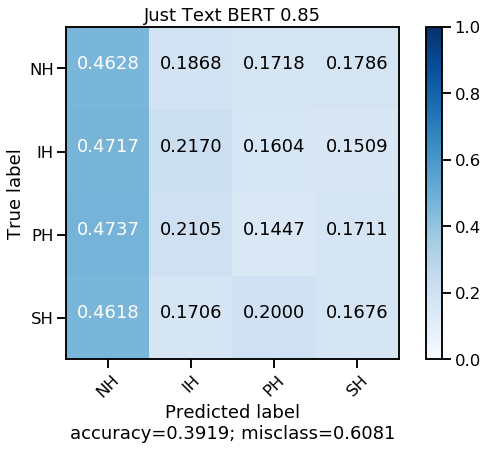

Test_ acc: 0.3918982571832313
Test_ f1 none: [0.57330754 0.09163347 0.049217   0.16011236]
Test_ f1 macro: 0.2185675928608665
Entrenando Run # 2
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.29384328358208955 	F-macro_val: 0.1894911860093252
Epoch 10 	acc_val: 0.32509328358208955 	F-macro_val: 0.2092717108018507
Epoch 20 	acc_val: 0.3512126865671642 	F-macro_val: 0.21203218206071922
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


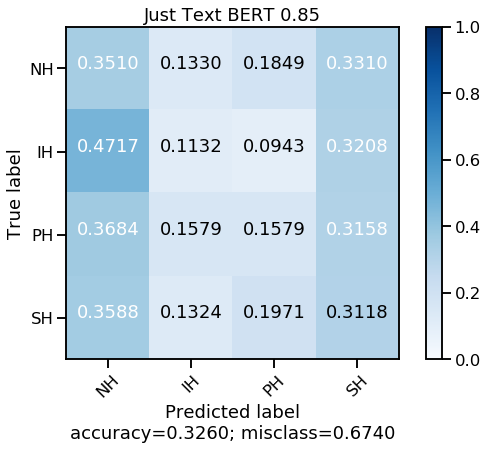

Test_ acc: 0.3259538389072068
Test_ f1 none: [0.47566653 0.06185567 0.05206074 0.20502901]
Test_ f1 macro: 0.19865298669322665
Entrenando Run # 3
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.1828358208955224 	F-macro_val: 0.13733517847729984
Epoch 10 	acc_val: 0.28404850746268656 	F-macro_val: 0.18873476107434203
Epoch 20 	acc_val: 0.28404850746268656 	F-macro_val: 0.19190219522796695
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


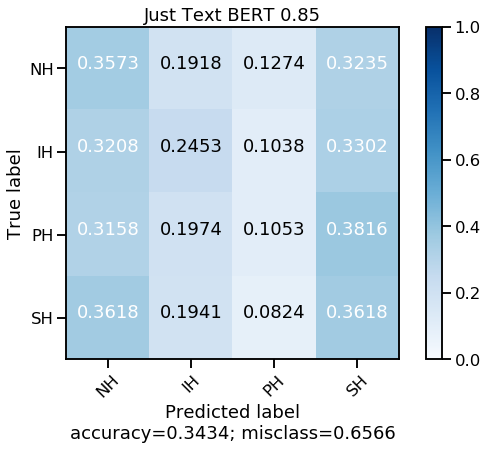

Test_ acc: 0.34338200659444185
Test_ f1 none: [0.48598131 0.1        0.04892966 0.2354067 ]
Test_ f1 macro: 0.21757941764609273
Entrenando Run # 4
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.2728544776119403 	F-macro_val: 0.17643919406861666
Epoch 10 	acc_val: 0.2994402985074627 	F-macro_val: 0.19272079430390013
Epoch 20 	acc_val: 0.3824626865671642 	F-macro_val: 0.23201189989865784
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


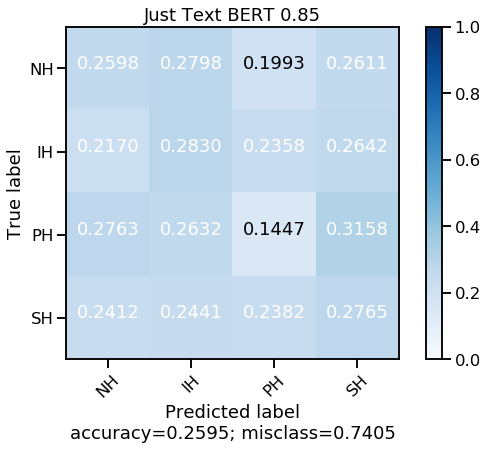

Test_ acc: 0.25953838907206783
Test_ f1 none: [0.38824078 0.08733624 0.04296875 0.2079646 ]
Test_ f1 macro: 0.18162759506478326
Entrenando Run # 5
Pesos de clases: [1. 1. 1. 1.]
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.28824626865671643 	F-macro_val: 0.1964663698416358
Epoch 10 	acc_val: 0.2891791044776119 	F-macro_val: 0.19482932671411987
Epoch 20 	acc_val: 0.32649253731343286 	F-macro_val: 0.20588708959979385
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


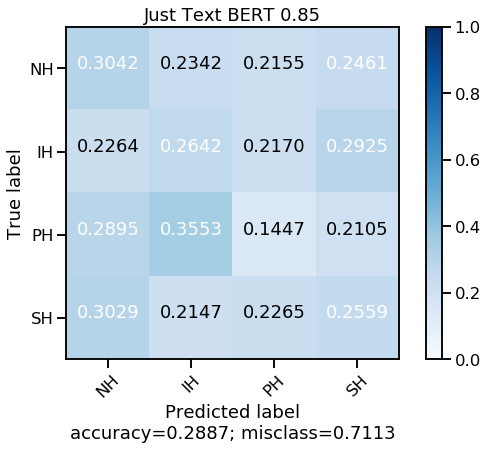

Test_ acc: 0.2887423457371644
Test_ f1 none: [0.43540456 0.09195402 0.04135338 0.20046083]
Test_ f1 macro: 0.19229319890459504


In [30]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}
  
prob=0.85

for trans in range(1,6): 
    print ("Entrenando Run #", trans)
    macro_augmented= np.load('../new_glove_augmented/harassment/Aumento_'+str(trans)+'-run_'+str(prob)+'_app1_Top1.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        
    bs=32
    b_dim=768
    
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']


    for i in range(len(sentences)):
        ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        
        #tws_train[i]
        final=' '
        frase=[final.join(tw_tr)]
        try: 
            vector= bc.encode(frase)[0]  
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)
        
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    
    objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
    objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
    
       
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        #vector=np.load("../BaS_Original/Original/"+str(i)+".npy")
        encoded_tok, tokens_valid =my_tokenizer(cleaner(tw_tr)[1])
    
        final=' '
        frase=[final.join(tokens_valid)]
        try: 
            vector= bc.encode(frase)[0]    
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    ###################################### TRANSFORMER ###############################
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))
    
    
    for epoch in range(26):
        model.train()
        DATA=data_gen(bs, 'Train')
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val'), model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val:",acc_val.numpy(), "\tF-macro_val:",fma_val.numpy())
    
    model.eval()
    print ("Testing run #",trans)
    predicciones = run_epoch(data_gen(bs, 'Test'), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-21])
    glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

    plot_confusion_matrix(glo_cm,["NH","IH","PH","SH"],"Just Text BERT 0.85")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 

In [31]:
print ("Acc:",np.mean(np.asarray(global_accs)))
print ("F-score:", np.mean(np.asarray(global_fmacros)))
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.85) Text - NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
m_temp

Acc: 0.3219029674988224
F-score: 0.20174415823391284
(0.85) Text - NIPS: 0.47172014423208974 0.08655588075370828 0.046905907366292146 0.2017947005835612


Confusion counts


array([[2778., 1642., 1439., 2146.],
       [ 181.,  119.,   86.,  144.],
       [ 131.,   90.,   53.,  106.],
       [ 587.,  325.,  321.,  467.]])

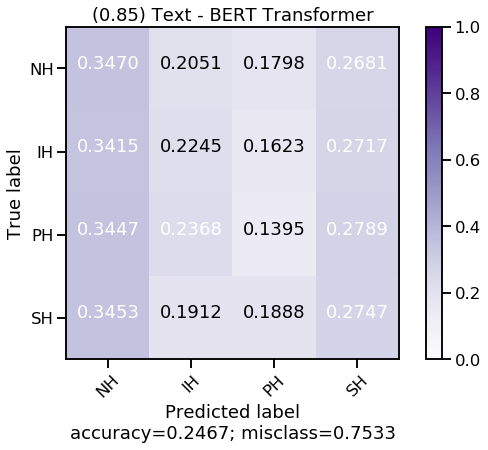

In [32]:
plot_confusion_matrix(normalize(m_temp),["NH","IH","PH","SH"],"(0.85) Text - BERT Transformer", cmap='Purples')